In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass
from uplift_dgf import get_daily_visitors, get_daily_conversions
from typing import List

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Set plot options
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [3]:
# Set print options
np.set_printoptions(suppress=True, precision=4, edgeitems = 7)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

In [4]:
# Create random generator
random_seed = 1923
rng = np.random.default_rng(random_seed)

## Set true parameters

In [5]:
# Avg. visitors per day & its noise, as Poisson distributions
lam_visitors = 100
lam_visitors_noise = 5

In [6]:
# Conversion rates
conversion_control = 0.15
conversion_experiment = 0.20
true_relative_uplift = (conversion_experiment /conversion_control) - 1

# Noise in conversion rates, as Beta distribution
# Mean = alpha / (alpha + beta)
conversion_noise_alpha = 3 
conversion_noise_beta = 100

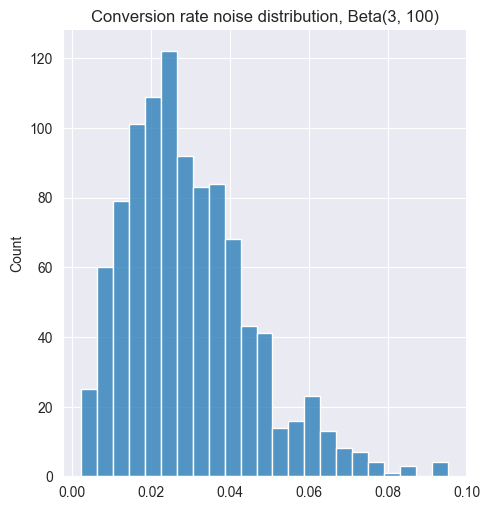

In [7]:
# Test conversion rate noise generation (will be randomly negated)
sns.displot(
    np.random.beta(conversion_noise_alpha, conversion_noise_beta, 1000)
)
_ = plt.title(f"Conversion rate noise distribution, Beta({conversion_noise_alpha}, {conversion_noise_beta})")

## Define data & model classes

In [8]:
@dataclass
class VariantData:
    visitors: int
    conversions: int

In [9]:
class ConversionRateModel:

    def __init__(self, conversion_alpha, conversion_beta):
        self.conversion_alpha = conversion_alpha
        self.conversion_beta = conversion_beta
    
    def create_model(self, data: List[VariantData]):

        # Get n. of visitors & conversions for each variant
        # 0: control, 1: experiment
        visitors = [variant.visitors for variant in data]
        conversions = [variant.conversions for variant in data]
        shape = len(data)

        # Define model
        with pm.Model() as model:

            # Conversion rate prior, same for all variants
            conversion_rate = pm.Beta(
                "conversion_rate",
                alpha = self.conversion_alpha,
                beta = self.conversion_beta,
                shape = shape
            )

            # Likelihood
            likelihood = pm.Binomial(
                "outcome",
                n = visitors,
                p = conversion_rate,
                observed = conversions,
                shape = shape
            )

            # Relative uplift
            relative_uplift = pm.Deterministic(
                "relative_uplift",
                (conversion_rate[1] / conversion_rate[0]) - 1
            )
            
        return model

In [14]:
def generate_variant_data(days: int, conversion_rates: List[float]):

    variant_data_list = []
    # Assuming conversion_rates[0] is control
    for rate in conversion_rates:
        visitors = get_daily_visitors(days, lam_visitors, lam_visitors_noise, rng)
        conversions = get_daily_conversions(visitors, rate, conversion_noise_alpha, conversion_noise_beta, rng)
        variant_data = VariantData(sum(visitors), sum(conversions))
        variant_data_list.append(variant_data)
    
    return variant_data_list

## Inference

### Weak prior

In [15]:
# Create model
weak_prior = ConversionRateModel(
    conversion_alpha = 2,
    conversion_beta = 10
)

#### Prior predictive check 

In [16]:
# Sample prior predictive distribution
with weak_prior.create_model(
    generate_variant_data(days = 6, conversion_rates=[conversion_control, conversion_experiment])
    ):
    weak_prior_predictive = pm.sample_prior_predictive(random_seed = random_seed)

Sampling: [conversion_rate, outcome]


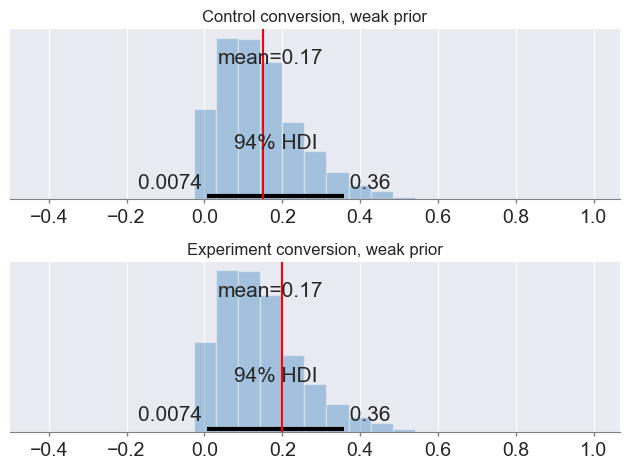

In [50]:
# Plot conversion rate priors
fig, ax = plt.subplots(2, sharex = True)
#plt.suptitle("weak conversion rate priors")

# Control
_ = az.plot_posterior(
    weak_prior_predictive.prior["conversion_rate"][:, :, 0],
    kind = "hist",
    ax = ax[0]
    )
_ = ax[0].axvline(conversion_control, color = "red")
_ = ax[0].set_title("Control conversion rate, weak prior")

# Experiment
_ = az.plot_posterior(
    weak_prior_predictive.prior["conversion_rate"][:, :, 0],
    kind = "hist",
    ax = ax[1]
    )
_ = ax[1].axvline(conversion_experiment, color = "red")
_ = ax[1].set_title("Experiment conversion rate, weak prior")

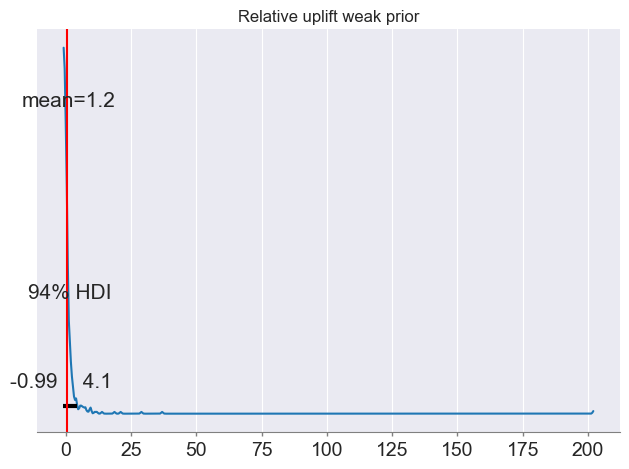

In [18]:
# Plot prior predictive distribution
_ = az.plot_posterior(
    weak_prior_predictive.prior["relative_uplift"],
    kind = "kde"
    )
_ = plt.axvline(true_relative_uplift, color = "red")
_ = plt.title("Relative uplift, weak prior")

#### Posterior

In [20]:
# Draw posterior samples
with weak_prior.create_model(
    generate_variant_data(days = 6, conversion_rates=[conversion_control, conversion_experiment])
    ):
    weak_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


c:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\Lib\site-packages\rich\live.py:
231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


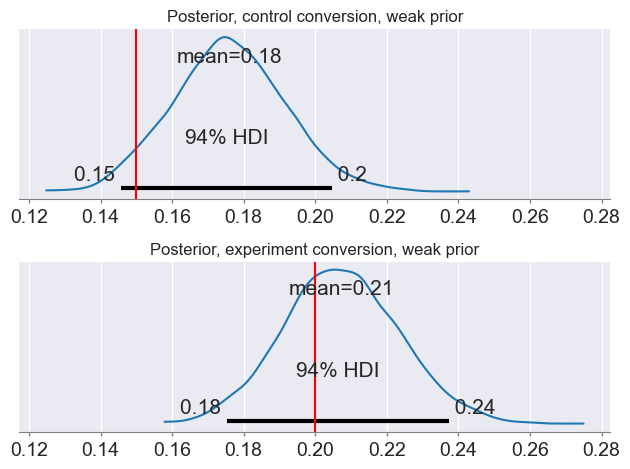

In [46]:
# Plot posterior conversion rates
fig, ax = plt.subplots(2, sharex = True)

# Control
_ = az.plot_posterior(
    weak_posterior.posterior["conversion_rate"][:, :, 0],
    kind = "kde",
    ax = ax[0]
    )
_ = ax[0].axvline(conversion_control, color = "red")
_ = ax[0].set_title("Posterior, control conversion rate, weak prior")

# Experiment
_ = az.plot_posterior(
    weak_posterior.posterior["conversion_rate"][:, :, 1],
    kind = "kde",
    ax = ax[1]
    )
_ = ax[1].axvline(conversion_experiment, color = "red")
_ = ax[1].set_title("Posterior, experiment conversion rate, weak prior")

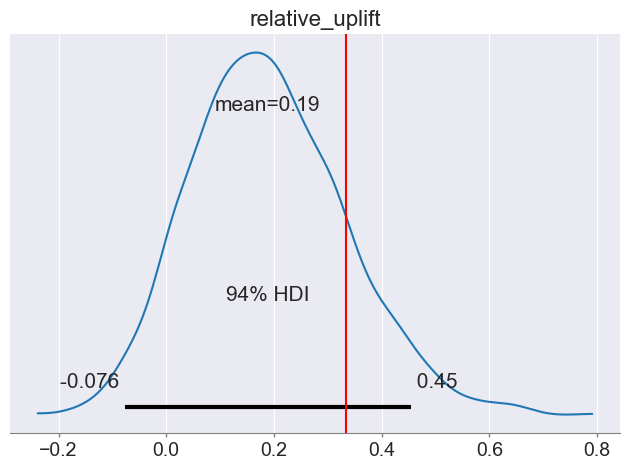

In [52]:
# Plot posterior relative uplift
_ = az.plot_posterior(
    weak_posterior.posterior["relative_uplift"],
    kind = "kde"
)
_ = plt.axvline(true_relative_uplift, color = "red")

### Strong prior

In [169]:
# Create model
# Mean of 0.15 = a: 0.15, b: 0.85
strong_prior = ConversionRateModel(
    conversion_alpha = 15 * 1.5,
    conversion_beta = 85 * 1.5
)

In [ ]:
# Sample prior predictive distribution
with strong_prior.create_model(
    generate_variant_data(days = 6, conversion_rates=[conversion_control, conversion_experiment])
    ):
    strong_prior_predictive = pm.sample_prior_predictive(random_seed = random_seed)

#### Prior predictive check

In [ ]:
# Plot conversion rate priors
fig, ax = plt.subplots(2, sharex = True)
#plt.suptitle("Strong conversion rate priors")

# Control
_ = az.plot_posterior(
    strong_prior_predictive.prior["conversion_rate"],
    kind = "hist",
    ax = ax[0]
    )
_ = ax[0].axvline(conversion_control, color = "red")
_ = ax[0].set_title("Control conversion rate, strong prior")

# Experiment
_ = az.plot_posterior(
    strong_prior_predictive.prior["conversion_rate"],
    kind = "hist",
    ax = ax[1]
    )
_ = ax[1].axvline(conversion_experiment, color = "red")
_ = ax[1].set_title("Experiment conversion rate, strong prior")

In [ ]:
# Plot prior predictive distribution
_ = az.plot_posterior(
    strong_prior_predictive.prior["relative_uplift"],
    kind = "kde"
    )
_ = plt.axvline(true_relative_uplift, color = "red")
_ = plt.title("Relative uplift, strong prior")

#### Posterior

Abstract the whole thing? Prior check & posterior sampling, plot methods for both

Think about how to do the Bayesian power analysis / preposterior check simulation first